In [45]:
import numpy as np  
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import SVAR
from statsmodels.tsa.base.datetools import dates_from_str
from statsmodels.tsa.stattools import grangercausalitytests

import matplotlib.transforms as mtransforms
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense
import plotly.graph_objs as go
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
import seaborn as sns

# Merged all the variables into dataset.csv
# Lets start by opening it

In [15]:
data = pd.read_csv('dataset.csv', sep=';', nrows=239)
data = data.drop(['i', 'dummy_crisis'], axis=1) #remove these rows for now
data


,month,emotion_index,CPI,consumer_confidence,unemployment
0,2003-11,0.743369,2.2,-12.5,3.5
1,2003-12,0.896814,2.0,-12.9,3.3
2,2004-01,0.063117,1.8,-13.3,3.5
3,2004-02,0.527418,1.6,-12.2,3.5
4,2004-03,-0.145724,1.7,-12.0,3.7
...,...,...,...,...,...
234,2023-06,0.378575,6.1,-16.1,-2.4
235,2023-07,0.884584,5.5,-15.1,-3.1
236,2023-08,0.260382,5.3,-17.5,-1.4
237,2023-09,0.256641,5.2,-16.0,-2.8


# Normalize the data with Z-score

In [16]:

# Assume df is your DataFrame
numeric_columns = ['emotion_index', 'CPI', 'consumer_confidence', 'unemployment']

# Create a new DataFrame to store the normalized data
data_normalized = data.copy()

# Convert the "month" column to datetime format
data_normalized['month'] = pd.to_datetime(data_normalized['month'])

# Apply z-score normalization to the numeric columns
data_normalized[numeric_columns] = data_normalized[numeric_columns].apply(zscore)


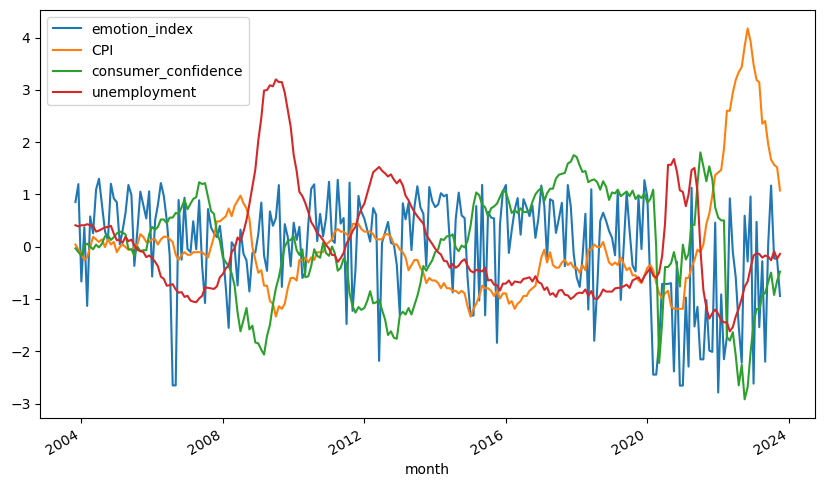

In [17]:
data_normalized.set_index('month').plot(kind='line', figsize=(10, 6))
plt.show()


## test for stationarity

In [18]:
# Initialize a list to store the results
results = []

columns = ['emotion_index', 'CPI', 'consumer_confidence', 'unemployment']

for column in columns:
    result = adfuller(data_normalized[column])
    results.append([column, result[0], result[1]] + [value for key, value in result[4].items()])

# Convert the results to a DataFrame
results_df = pd.DataFrame(results, columns=['Variable', 'ADF Statistic', 'p-value', '1%', '5%', '10%'])

# Print the results
print(results_df)

# Optionally, save the results to a CSV file
results_df.to_csv('adfuller_results.csv', index=False)

              Variable  ADF Statistic   p-value        1%        5%       10%
0        emotion_index      -2.353029  0.155435 -3.458980 -2.874135 -2.573482
1                  CPI      -1.860453  0.350888 -3.459620 -2.874415 -2.573632
2  consumer_confidence      -2.947922  0.040052 -3.458487 -2.873919 -2.573367
3         unemployment      -2.646121  0.083835 -3.459752 -2.874473 -2.573663


### emotion_index, CPI, i,unemployment are non stationary

In [19]:
# List of columns to apply differencing
columns = ['emotion_index', 'CPI', 'consumer_confidence', 'unemployment']
# Create a new DataFrame to store the stationary data
data_stationary = pd.DataFrame()

# Apply differencing to each column
for column in columns:
    data_stationary[column] = data[column].diff().dropna()
                             
# Drop the first row which is NaN
data_stationary = data_stationary.dropna()
data_stationary


,emotion_index,CPI,consumer_confidence,unemployment
1,0.153445,-0.2,-0.4,-0.2
2,-0.833698,-0.2,-0.4,0.2
3,0.464301,-0.2,1.1,0.0
4,-0.673142,0.1,0.2,0.2
5,0.765989,0.4,-0.3,-0.2
...,...,...,...,...
234,1.001838,-0.9,1.2,-0.2
235,0.506009,-0.6,1.0,-0.7
236,-0.624202,-0.2,-2.4,1.7
237,-0.003741,-0.1,1.5,-1.4


In [20]:
# # Apply second differencing to emotion index
# data_stationary['emotion_index'] = data['emotion_index'].diff().diff().dropna()

# # Drop the first row which is NaN
# data_stationary = data_stationary.dropna()              

# data_stationary

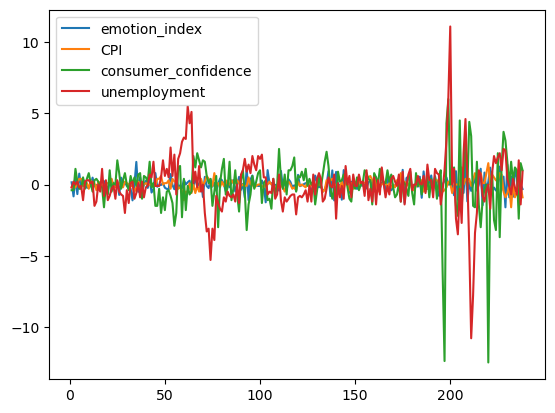

In [21]:
data_stationary.plot(kind='line')
plt.show()

# Remove time-dependent variance

In [22]:
data_stationary['month'] = data['month'].copy()
data_stationary['month'] = data_stationary['month'].drop(data_stationary['month'].index[:0])
data_stationary['month'] = pd.to_datetime(data_stationary['month'])
# Extract the year from 'month'
data_stationary['year'] = data_stationary['month'].dt.year
data_stationary


,emotion_index,CPI,consumer_confidence,unemployment,month,year
1,0.153445,-0.2,-0.4,-0.2,2003-12-01,2003
2,-0.833698,-0.2,-0.4,0.2,2004-01-01,2004
3,0.464301,-0.2,1.1,0.0,2004-02-01,2004
4,-0.673142,0.1,0.2,0.2,2004-03-01,2004
5,0.765989,0.4,-0.3,-0.2,2004-04-01,2004
...,...,...,...,...,...,...
234,1.001838,-0.9,1.2,-0.2,2023-06-01,2023
235,0.506009,-0.6,1.0,-0.7,2023-07-01,2023
236,-0.624202,-0.2,-2.4,1.7,2023-08-01,2023
237,-0.003741,-0.1,1.5,-1.4,2023-09-01,2023


In [23]:
# Calculate the standard deviation for each year
std_dev = data_stationary.groupby('year').std()

# Subtract the standard deviation for each year
for column in ['emotion_index', 'CPI', 'consumer_confidence', 'unemployment']:
    data_stationary[column] = data_stationary.groupby('year')[column].transform(lambda x: x - x.std())

# Drop the lines with NaN values
data_stationary = data_stationary.dropna()

# Print the updated DataFrame
print(data_stationary)

     emotion_index       CPI  consumer_confidence  unemployment      month  \
2        -1.308093 -0.445412            -0.910496     -0.379707 2004-01-01   
3        -0.010094 -0.445412             0.589504     -0.579707 2004-02-01   
4        -1.147537 -0.145412            -0.310496     -0.379707 2004-03-01   
5         0.291593  0.154588            -0.810496     -0.779707 2004-04-01   
6        -0.618268  0.154588            -0.810496     -0.679707 2004-05-01   
..             ...       ...                  ...           ...        ...   
234       0.057125 -1.418116            -0.239946     -1.356671 2023-06-01   
235      -0.438704 -1.118116            -0.439946     -1.856671 2023-07-01   
236      -1.568916 -0.718116            -3.839946      0.543329 2023-08-01   
237      -0.948454 -0.618116             0.060054     -2.556671 2023-09-01   
238      -1.262251 -1.418116            -0.439946     -0.256671 2023-10-01   

     year  
2    2004  
3    2004  
4    2004  
5    2004  
6  

# remove the seasonality in the data

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Create a new DataFrame to store the data without seasonality
data_without_seasonality = data_stationary.copy()

# Loop over the columns in the DataFrame
for column in data_stationary.columns:
    # Skip the 'month' and 'year' columns
    if column not in ['month', 'year']:
        # Perform seasonal decomposition with a monthly frequency
        decomposition = seasonal_decompose(data_stationary[column], model='additive', period=12)

        # Get the seasonality component
        seasonality = decomposition.seasonal

        # Remove the seasonality component from the original data
        data_without_seasonality[column] = data_stationary[column] - seasonality

# Drop the 'year' column

data_without_seasonality = data_without_seasonality.drop(['year', 'month'], axis=1)

# Print the updated DataFrame
print(data_without_seasonality)


     emotion_index       CPI  consumer_confidence  unemployment
2        -1.344304 -0.425338            -1.134448     -0.167880
3         0.176552 -0.474561             0.554019     -0.581375
4        -1.325804 -0.145932             0.368583     -0.565265
5         0.248191  0.195096            -0.134238     -0.774025
6        -0.709397  0.138529            -1.116324     -0.631688
..             ...       ...                  ...           ...
234      -0.034003 -1.434175            -0.545774     -1.308652
235      -0.233311 -1.127326            -0.984571     -1.686504
236      -1.515313 -0.708947            -3.610506      0.268263
237      -1.073647 -0.605537            -0.002302     -2.476154
238      -1.184841 -1.462874            -0.426993     -0.344035

[237 rows x 4 columns]


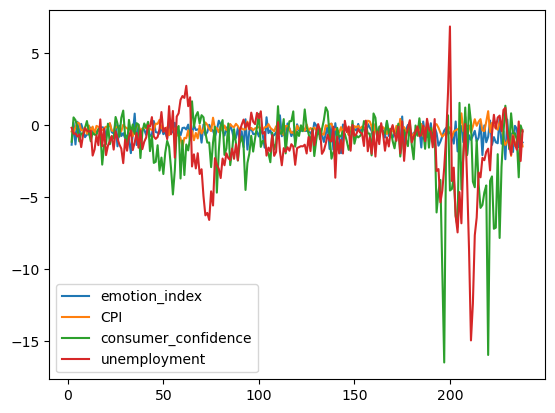

In [25]:
data_without_seasonality.plot(kind='line')
plt.show()

# Outlier Analysis

In [26]:
# #remove outliers
# # Calculate the absolute Z-scores of each value in the DataFrame
# z_scores = np.abs(stats.zscore(data_without_seasonality))

# # Only keep rows in the DataFrame with all Z-scores less than the absolute value of 3
# data_stationary = data_without_seasonality[(z_scores < 3).all(axis=1)]

# # 
# # Calculate Q1, Q3, and IQR for the 'emotion_index' column
# Q1 = data_without_seasonality['emotion_index'].quantile(0.25)
# Q3 = data_without_seasonality['emotion_index'].quantile(0.75)
# IQR = Q3 - Q1

# # Only keep rows in the DataFrame that have 'emotion_index' within the IQR
# data_without_seasonality = data_without_seasonality[~((data_without_seasonality['emotion_index'] < (Q1 - 1.5 * IQR)) | (data_without_seasonality['emotion_index'] > (Q3 + 1.5 * IQR)))]

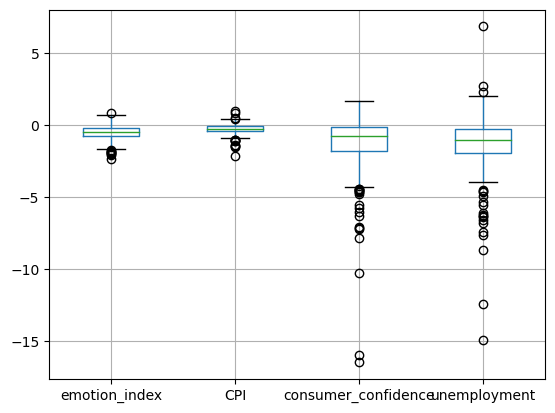

In [27]:
data_without_seasonality.boxplot()
plt.show()

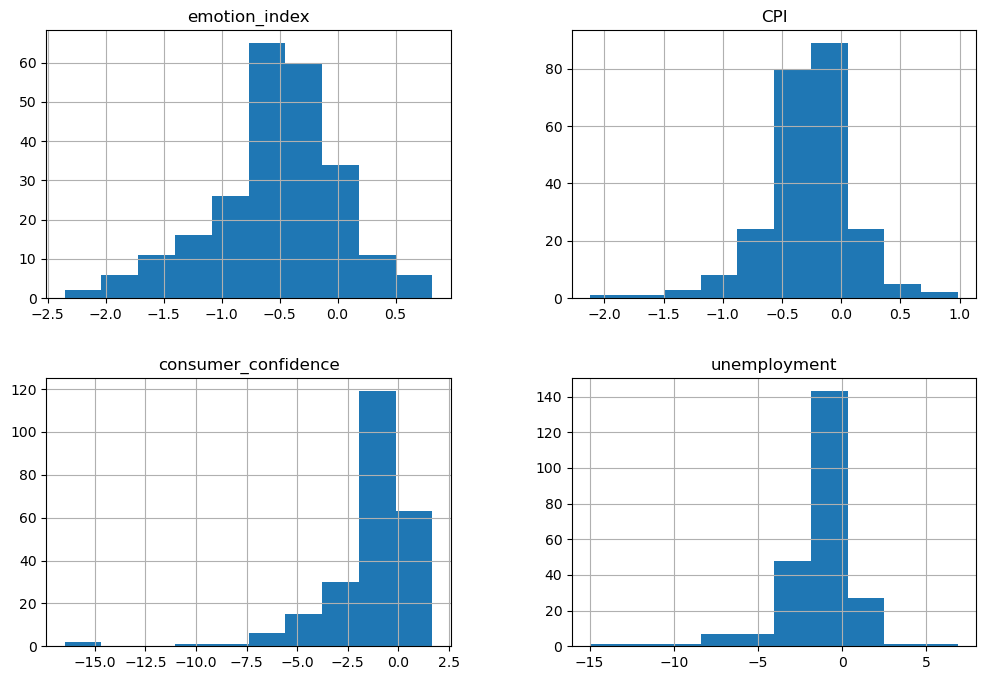

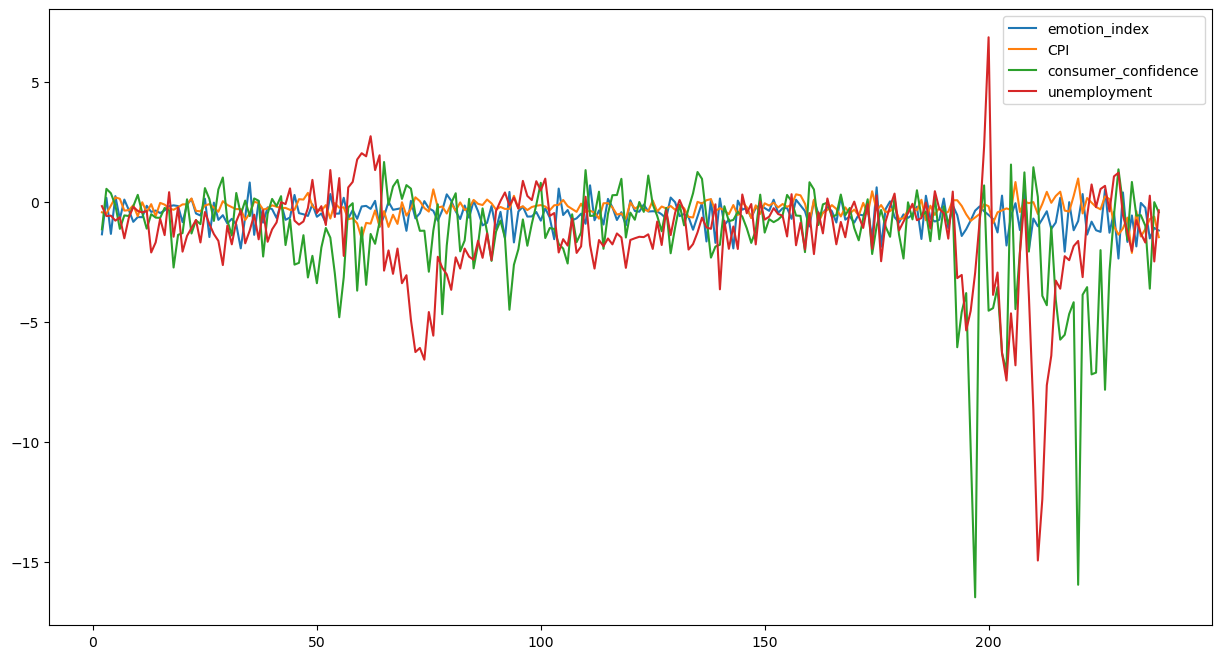

In [28]:
_ = data_without_seasonality.hist(figsize=(12, 8), layout=(2, 2))
data_without_seasonality.plot(figsize=(15, 8))
plt.show()


In [29]:
from scipy.stats import kstest

# Assume 'data_stationary' is your time series data with multiple columns
for column in data_without_seasonality.columns:
    ks_statistic, p_value = kstest(data_without_seasonality[column], 'norm', args=(data_without_seasonality[column].mean(), data_without_seasonality[column].std()))
    print(f'Column: {column}')
    print('KS Statistic:', ks_statistic)
    print('P-Value:', p_value)
    print('---')

Column: emotion_index
KS Statistic: 0.07643271445182809
P-Value: 0.1190550163181433
---
Column: CPI
KS Statistic: 0.09990828062190549
P-Value: 0.01639081181184796
---
Column: consumer_confidence
KS Statistic: 0.1683991254398836
P-Value: 2.4119095204716516e-06
---
Column: unemployment
KS Statistic: 0.1518975340506514
P-Value: 3.068526221772656e-05
---


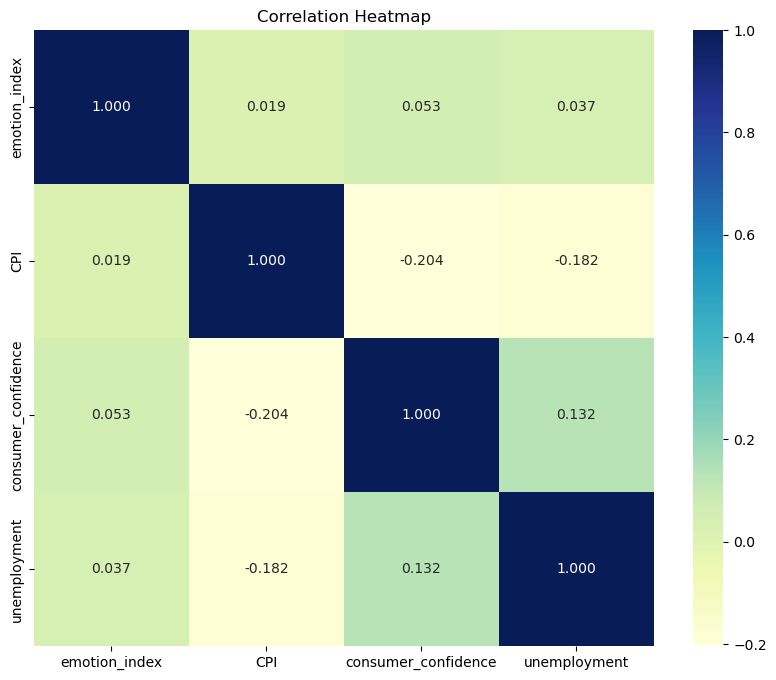

In [30]:
# Calculate correlations
corr = data_without_seasonality.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".3f", cmap='YlGnBu')

# Add a title
plt.title('Correlation Heatmap')

# Show the plot
plt.show()

# Test again for Stationary

In [31]:
# Initialize a list to store the results
results_stationary = []

columns = ['emotion_index', 'CPI', 'consumer_confidence', 'unemployment']

for column in columns:
    result = adfuller(data_without_seasonality[column])
    results_stationary.append([column, result[0], result[1]] + [value for key, value in result[4].items()])

# Convert the results to a DataFrame
results_stationary_df = pd.DataFrame(results_stationary, columns=['Variable', 'ADF Statistic', 'p-value', '1%', '5%', '10%'])

# Print the results
print(results_stationary_df)

# Optionally, save the results to a CSV file
results_stationary_df.to_csv('adfuller_results_stationary.csv', index=False)

              Variable  ADF Statistic   p-value        1%        5%       10%
0        emotion_index      -3.518468  0.007525 -3.458980 -2.874135 -2.573482
1                  CPI      -4.808101  0.000052 -3.459752 -2.874473 -2.573663
2  consumer_confidence      -2.273611  0.180620 -3.460291 -2.874709 -2.573789
3         unemployment      -3.746305  0.003507 -3.459885 -2.874531 -2.573694


In [32]:
# Apply differencing to 'emotion_index' and 'consumer_confidence' columns
data_without_seasonality['emotion_index'] = data_without_seasonality['emotion_index'].diff().dropna()
data_without_seasonality['consumer_confidence'] = data_without_seasonality['consumer_confidence'].diff().dropna()

# Drop the first row which is NaN
data_without_seasonality = data_without_seasonality.dropna()

# Print the updated DataFrame
print(data_without_seasonality)


     emotion_index       CPI  consumer_confidence  unemployment
3         1.520856 -0.474561             1.688467     -0.581375
4        -1.502356 -0.145932            -0.185436     -0.565265
5         1.573995  0.195096            -0.502821     -0.774025
6        -0.957587  0.138529            -0.982086     -0.631688
7         0.814107 -0.354623             0.561203     -1.509540
..             ...       ...                  ...           ...
234       1.814218 -1.434175             0.017914     -1.308652
235      -0.199308 -1.127326            -0.438797     -1.686504
236      -1.282002 -0.708947            -2.625936      0.268263
237       0.441666 -0.605537             3.608204     -2.476154
238      -0.111194 -1.462874            -0.424691     -0.344035

[236 rows x 4 columns]


In [33]:
# Initialize a list to store the results
results_stationary = []

columns = ['emotion_index', 'CPI', 'consumer_confidence', 'unemployment']

for column in columns:
    result = adfuller(data_without_seasonality[column])
    results_stationary.append([column, result[0], result[1]] + [value for key, value in result[4].items()])

# Convert the results to a DataFrame
results_stationary_df = pd.DataFrame(results_stationary, columns=['Variable', 'ADF Statistic', 'p-value', '1%', '5%', '10%'])

# Print the results
print(results_stationary_df)

# Optionally, save the results to a CSV file
results_stationary_df.to_csv('adfuller_results_stationary.csv', index=False)

              Variable  ADF Statistic       p-value        1%        5%  \
0        emotion_index     -10.617919  5.612135e-19 -3.459233 -2.874245   
1                  CPI      -4.805278  5.313547e-05 -3.459885 -2.874531   
2  consumer_confidence      -7.298939  1.354577e-10 -3.460291 -2.874709   
3         unemployment      -3.769496  3.235294e-03 -3.460019 -2.874590   

        10%  
0 -2.573541  
1 -2.573694  
2 -2.573789  
3 -2.573725  


In [34]:
# Specify the split point
split_point = int(len(data_without_seasonality) * 0.95)  # 80% of the data for training

# Split the data into train and test sets
train_data = data_without_seasonality[:split_point]
test_data = data_without_seasonality[split_point:]

# Print the shapes of the train and test sets
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)


Train data shape: (224, 4)
Test data shape: (12, 4)


# Modeling VAR

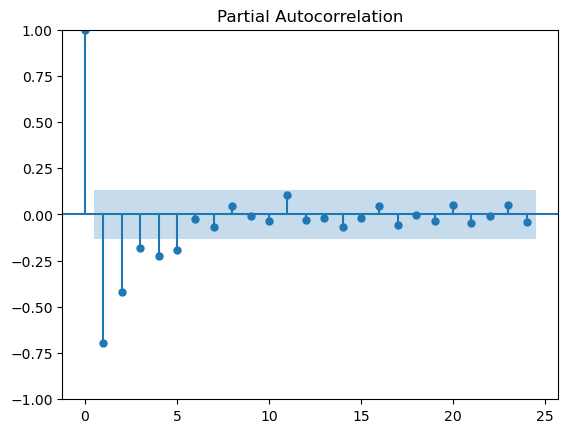

In [35]:
from statsmodels.graphics.tsaplots import plot_pacf

# Plot the partial autocorrelation function for 'emotion_index'
plot_pacf(train_data['emotion_index'])
plt.show()


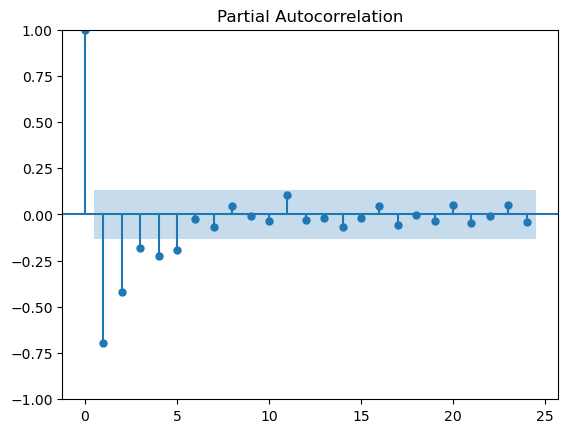

In [36]:

# Plot the partial autocorrelation function for 'emotion_index'
plot_pacf(train_data['emotion_index'])
plt.show()


#### it shows that the first six terms are significant and outside the confidence intervals denoted by the shaded blue region. Thus it is appropriate to take 6 AR terms for modeling/forecasting the emotion index.

In [37]:
train_data

,emotion_index,CPI,consumer_confidence,unemployment
3,1.520856,-0.474561,1.688467,-0.581375
4,-1.502356,-0.145932,-0.185436,-0.565265
5,1.573995,0.195096,-0.502821,-0.774025
6,-0.957587,0.138529,-0.982086,-0.631688
7,0.814107,-0.354623,0.561203,-1.509540
...,...,...,...,...
222,-1.691539,0.169896,0.317914,-0.586934
223,0.540492,-0.023255,-3.638797,0.735214
224,-0.358093,-0.204876,0.074064,-0.210019
225,-0.068188,-0.301466,5.108204,0.545564


In [38]:
# Fit the model
model = VAR(train_data)
results = model.fit(maxlags=12, ic='aic')

# Now results is a VARResults object and has the k_ar attribute
lag_order = results.k_ar

results.summary()

/Users/josenamora/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 02, Dec, 2023
Time:                     00:53:56
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    1.24812
Nobs:                     212.000    HQIC:                 -0.600874
Log likelihood:          -810.615    FPE:                   0.161845
AIC:                     -1.85514    Det(Omega_mle):       0.0704501
--------------------------------------------------------------------
Results for equation emotion_index
                             coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------
const                          -0.038991         0.104954           -0.372           0.710
L1.emotion_index               -1.345040         0.077450          -17.366           0.000
L1.CPI      

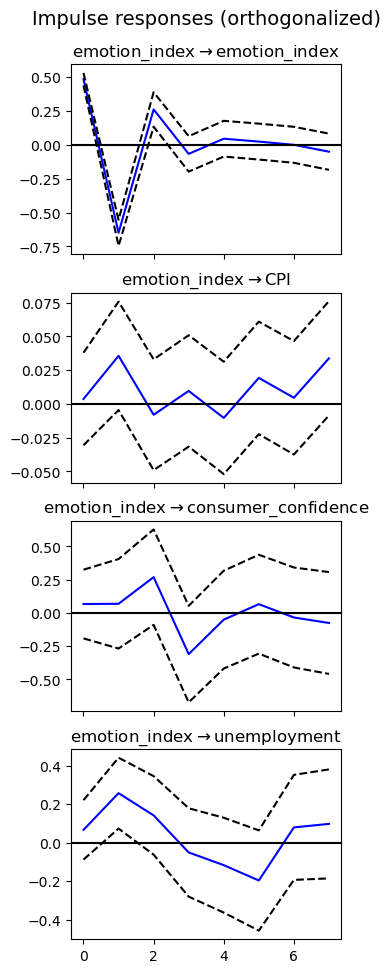

In [39]:
# Import the necessary modules
import matplotlib.pyplot as plt

# Get the impulse response functions over a longer period
irf = results.irf(7)

# Create the plot and get the figure object
fig = irf.plot(impulse='emotion_index', orth=True, signif=0.05)

# Set the figure size
fig.set_size_inches(3, 10)

# Display the plot
plt.show()


https://www.ikigailabs.io/multivariate-time-series-forecasting-in-python-settings/vector-autoregression-python

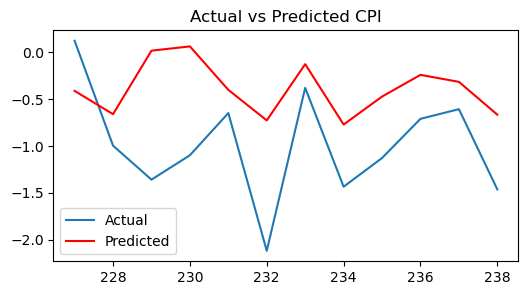

In [40]:

# Generate predictions
lag_order = results.k_ar
predictions = results.forecast(train_data.values[-lag_order:], len(test_data))

# Convert predictions to DataFrame for easier plotting
predictions_df = pd.DataFrame(predictions, index=test_data.index, columns=test_data.columns)

# Plot actual vs predicted values for 'CPI'
plt.figure(figsize=(6,3))
plt.plot(test_data.index, test_data['CPI'], label='Actual')
plt.plot(predictions_df.index, predictions_df['CPI'], color='red', label='Predicted')
plt.title('Actual vs Predicted CPI')
plt.legend()
plt.show()

# Training a model to forecast inflation

In [41]:
# Dividir o dataset de 2003 a 2019 que vai ser o objeto de treino
data = pd.read_csv('dataset.csv', sep=';')
# Convert the 'month' column to datetime format
data['month'] = pd.to_datetime(data['month']).dt.to_period('M')
# Set the 'month' column as the index
data.set_index('month', drop=True)
#Y = data[['CPI']].values
train_data = data.iloc[0:193]
data = pd.DataFrame(train_data, columns=data.columns, index=data.index)
data = data.drop(data.index[193:])
X = data[['emotion_index']]
data.to_csv('dataset_2003-19.csv')

In [42]:
# Dividir o dataset de 2008 a 2010 
data = pd.read_csv('dataset.csv', sep=';')
# Convert the 'month' column to datetime format
data['month'] = pd.to_datetime(data['month']).dt.to_period('M')
# Set the 'month' column as the index
data.set_index('month', inplace=True)
data08_10 = data.iloc[38:74]
data = pd.DataFrame(data08_10,columns=data.columns, index=data.index)
data = data.drop(data.index[0:38].union(data.index[74:]))
data.to_csv('dataset_2008-10.csv')

# train and test the model

### Previsão do CPI usando LSTM com o dataset completo

In [43]:

data = pd.read_csv('dataset.csv', sep=';')
# Convert the 'month' column to datetime format
data['month'] = pd.to_datetime(data['month']).dt.to_period('M')
# Set the 'month' column as the index
data.set_index('month', drop=True)
data = data.drop(data.index[239:])
Y = data[['CPI']].values
Y = Y.reshape((-1,1))
split_percent = 0.80
split = int(split_percent*len(Y))
Y_train = Y[:split]
Y_test = Y[split:]
data_train = data['month'][:split]
data_test = data['month'][split:]
data_train_str = data_train.astype(str)
data_test_str = data_test.astype(str)
print(len(Y_train))
print(len(Y_test))
look_back = 15
train_generator = TimeseriesGenerator(Y_train, Y_train, length=look_back, batch_size=20)     
test_generator = TimeseriesGenerator(Y_test, Y_test, length=look_back, batch_size=1)
model = Sequential()
model.add(
    LSTM(10,
        activation='relu',
        input_shape=(look_back,1))
)
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

num_epochs = 25
model.fit(train_generator, epochs=num_epochs, verbose=1)

prediction = model.predict(test_generator)

Y_train = Y_train.reshape((-1))
Y_test = Y_test.reshape((-1))
prediction = prediction.reshape((-1))

trace1 = go.Scatter(
    x = data_train_str,
    y = Y_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = data_test_str,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = data_test_str,
    y = Y_test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "CPI"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()


191
48


Epoch 1/25
9/9 [==============================] - 3s 9ms/step - loss: 3.8642
Epoch 2/25
9/9 [==============================] - 0s 7ms/step - loss: 3.6774
Epoch 3/25
9/9 [==============================] - 0s 7ms/step - loss: 3.5232
Epoch 4/25
9/9 [==============================] - 0s 7ms/step - loss: 3.3637
Epoch 5/25
9/9 [==============================] - 0s 8ms/step - loss: 3.1882
Epoch 6/25
9/9 [==============================] - 0s 9ms/step - loss: 3.0074
Epoch 7/25
9/9 [==============================] - 0s 7ms/step - loss: 2.7704
Epoch 8/25
9/9 [==============================] - 0s 8ms/step - loss: 2.5096
Epoch 9/25
9/9 [==============================] - 0s 7ms/step - loss: 2.1078
Epoch 10/25
9/9 [==============================] - 0s 7ms/step - loss: 1.6664
Epoch 11/25
9/9 [==============================] - 0s 9ms/step - loss: 1.3495
Epoch 12/25
9/9 [==============================] - 0s 8ms/step - loss: 1.2785
Epoch 13/25
9/9 [==============================] - 0s 6ms/step - loss: 1.

In [46]:
data = pd.read_csv('dataset_2008-10.csv')
Y = data[['CPI']].values
Y = Y.reshape((-1,1))
split_percent = 0.80
split = int(split_percent*len(Y))
Y_train = Y[:split]
Y_test = Y[split:]
data_train = data['month'][:split]
data_test = data['month'][split:]
data_train_str = data_train.astype(str)
data_test_str = data_test.astype(str)
print(len(Y_train))
print(len(Y_test))
look_back = 2
train_generator = TimeseriesGenerator(Y_train, Y_train, length=look_back, batch_size=20)     
test_generator = TimeseriesGenerator(Y_test, Y_test, length=look_back, batch_size=1)
model = Sequential()
model.add(
    LSTM(10,
        activation='relu',
        input_shape=(look_back,1))
)
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

num_epochs = 25
model.fit(train_generator, epochs=num_epochs, verbose=1)

prediction = model.predict(test_generator)

Y_train = Y_train.reshape((-1))
Y_test = Y_test.reshape((-1))
prediction = prediction.reshape((-1))

trace1 = go.Scatter(
    x = data_train_str,
    y = Y_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = data_test_str,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = data_test_str,
    y = Y_test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "CPI"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()




28
8
Epoch 1/25
2/2 [==============================] - 2s 6ms/step - loss: 7.7684
Epoch 2/25
2/2 [==============================] - 0s 7ms/step - loss: 7.7014
Epoch 3/25
2/2 [==============================] - 0s 8ms/step - loss: 7.6558
Epoch 4/25
2/2 [==============================] - 0s 6ms/step - loss: 7.6282
Epoch 5/25
2/2 [==============================] - 0s 5ms/step - loss: 7.5813
Epoch 6/25
2/2 [==============================] - 0s 9ms/step - loss: 7.5179
Epoch 7/25
2/2 [==============================] - 0s 6ms/step - loss: 7.4914
Epoch 8/25
2/2 [==============================] - 0s 6ms/step - loss: 7.4290
Epoch 9/25
2/2 [==============================] - 0s 6ms/step - loss: 7.3863
Epoch 10/25
2/2 [==============================] - 0s 37ms/step - loss: 7.3453
Epoch 11/25
2/2 [==============================] - 0s 9ms/step - loss: 7.3060
Epoch 12/25
2/2 [==============================] - 0s 14ms/step - loss: 7.2682
Epoch 13/25
2/2 [==============================] - 0s 5ms/step - l

1/1 [==============================] - 0s 32ms/step


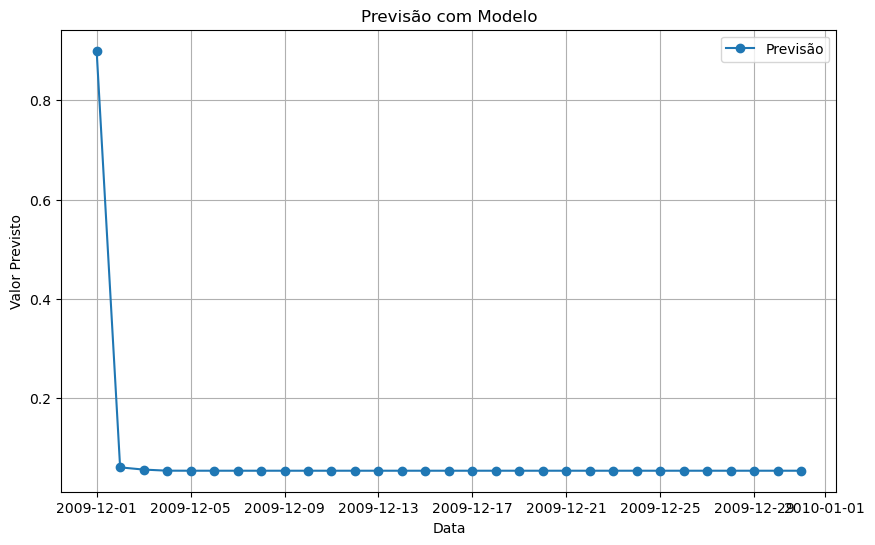

In [47]:
data = pd.read_csv('dataset_2008-10.csv')
Y = data[['CPI']].values
Y = Y.reshape((-1))

def predict(num_prediction, model):
    prediction_list = Y[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list

def predict_dates(num_prediction):
    # Assuming 'data' is your DataFrame
    data['month'] = pd.to_datetime(data['month'])
    # Check the type of the index
    
    if isinstance(data.index, pd.RangeIndex):
        # If the index is a RangeIndex, create a DatetimeIndex
        data.index = pd.to_datetime(data['month']).dt.to_period('M')
    else:
        # If the index is already a DatetimeIndex, do nothing
        pass
    
    last_date = data['month'].max()  # Use max to get the latest date
    last_date_timestamp = pd.Timestamp(last_date).to_pydatetime()
    prediction_dates = pd.date_range(last_date_timestamp, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 30
forecast = predict(num_prediction, model)
forecast_dates = predict_dates(num_prediction)
plt.figure(figsize=(10, 6))
plt.plot(forecast_dates, forecast, label='Previsão', marker='o')
plt.title('Previsão com Modelo')
plt.xlabel('Data')
plt.ylabel('Valor Previsto')
plt.legend()
plt.grid(True)
plt.show()